# SVM with sigmoid kernel

The goal of this notebook is to find the best parameters for polynomial kernel. We also want to check if the parameters depend on stock.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)
* gamma (default 1/number_of_features, so 1 in our case)
* coef0 (default 0.0)

Sigmoid kernel function: $(\tanh(\gamma \langle x,x'\rangle + coef0))$

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['10795', '12098', '11618', '2051', '4481', '3107', '1243', '11234'][:5]

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_data(s, data_dir='data/INDEX/', cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 10795: 4496
Testing set length for 10795: 1498
Cross-validation set length for 10795: 1498
Training set length for 12098: 3592
Testing set length for 12098: 1197
Cross-validation set length for 12098: 1197
Training set length for 11618: 3792
Testing set length for 11618: 1264
Cross-validation set length for 11618: 1264
Training set length for 2051: 3635
Testing set length for 2051: 1211
Cross-validation set length for 2051: 1211
Training set length for 4481: 3903
Testing set length for 4481: 1301
Cross-validation set length for 4481: 1301


In [3]:
dfs[stocks[0]].head()

,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-13 10:57:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1489.0, 1874.0), (1490.0, 4866.0), (1491.0, ...",1488.0,1489.0,1488.5,1874.0,800.0,1.0,-0.401645
2013-09-13 10:59:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1490.0, 220.0), (1491.0, 3642.0), (1492.0, 5...",1488.0,1490.0,1489.0,220.0,3967.0,1.0,0.894913
2013-09-13 11:00:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1491.0, 905.0), (1492.0, 5591.0), (1493.0, 6...",1489.0,1491.0,1490.0,905.0,2807.0,1.0,0.512392
2013-09-13 11:01:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1492.0, 4077.0), (1493.0, 6616.0), (1494.0, ...",1490.0,1492.0,1491.0,4077.0,1563.0,0.0,-0.445745
2013-09-13 11:03:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1490.0, 1738.0), (1491.0, 4491.0), (1492.0, ...",1488.0,1490.0,1489.0,1738.0,4642.0,1.0,0.455172


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0, degree=3, coef0=0.0, decision_function_shape='ovr'):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree, coef0=coef0, 
                  decision_function_shape=decision_function_shape)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults for parameters C and gamma.

Next we will choose parameter coef0 for SVM with gamma and C set to the best values we got.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced or removed.

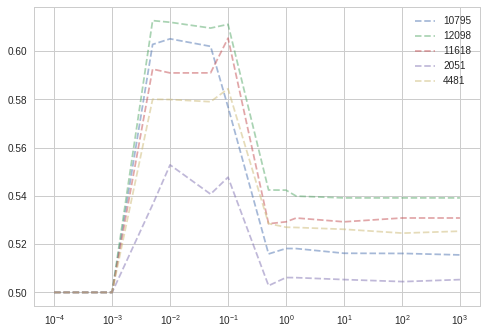

In [5]:
cs = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 1.5, 10, 100, 110, 1000]
df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'sigmoid', C=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.5)
    df_css[s] = df_cs
    
plt.legend()

##### Best values of C parameter

Choice of parameter C should be small - less than 0.1

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 0.01
For 12098 the best is 0.005
For 11618 the best is 0.1
For 2051 the best is 0.01
For 4481 the best is 0.1


##### Influence of C parameter

The score difference between SVM with the worst choice of parameter **C** and the best choice one is shown on the output below. For scoring method we used *roc_area*. For three stocks **10795**, **12098** and **11618** it can affect the prediction by 0.1, for the rest the difference is less.

In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.10515292132085208
For 12098 the diff between best and worst 0.11270883655394526
For 11618 the diff between best and worst 0.10543709300666215
For 2051 the diff between best and worst 0.0528815464271879
For 4481 the diff between best and worst 0.08444113404743325


### Gamma

Gamma is a parameter which has influence over decision region - the bigger it is, the bigger influence every single row of data has. When gamma is low the decision region is very broad. When gamma is high it can even create islands of decision-boundaries around data points.

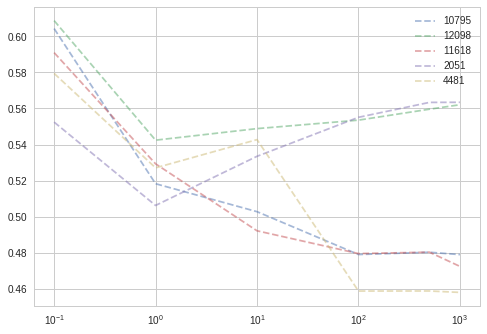

In [8]:
gammas = [0.1, 1, 10, 100, 500, 1000]

df_gammas = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_gamma = pd.DataFrame(index=gammas)
    df_gamma['roc'] = np.zeros(len(df_gamma))
    for g in gammas:
        reg_svm = svm_classification(dfs[s], 'sigmoid', gamma=g)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))

        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_gamma.loc[g] = logit_roc_auc
    plt.plot(df_gamma, linestyle='--', label=s, marker='x', alpha=0.5)
    df_gammas[s] = df_gamma
    
plt.legend()

##### Best values of gamma

There is no rule, how to set this parameter - for stock **2051** the value is very large, for the rest it is rather small.

In [9]:
for s in stocks:
    idx = df_gammas[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 0.1
For 12098 the best is 0.1
For 11618 the best is 0.1
For 2051 the best is 1000.0
For 4481 the best is 0.1


##### Influence of gamma

The score difference between SVM with the worst choice of **gamma** and the best choice one is shown on the output below. For scoring method we used *roc_area*. For stocks **10795**, **11618** and **4481** the difference is more than 0.1, so it's definitelly worth to experiment more.

In [10]:
for s in stocks:
    err_max = df_gammas[s]['roc'].max()
    err_min = df_gammas[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.12553053698638938
For 12098 the diff between best and worst 0.06639995974235091
For 11618 the diff between best and worst 0.11871624818801119
For 2051 the diff between best and worst 0.05728311336865144
For 4481 the diff between best and worst 0.1216239861909153


### Coef0

For sigmoid kernel we use function:
$(\tanh(\gamma \langle x,x'\rangle + r))$, where r is specified by coef0.

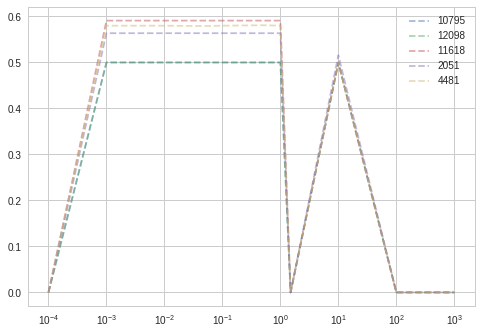

In [11]:
coeffs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10]

df_coefs = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_coef = pd.DataFrame(index=cs)
    df_coef['roc'] = np.zeros(len(df_coef))
    for c in coeffs:
        reg_svm = svm_classification(dfs[s], 'sigmoid', coef0=c, C=df_css[s]['roc'].idxmax(), 
                                     gamma=df_gammas[s]['roc'].idxmax())
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_coef.loc[c] = logit_roc_auc
    plt.plot(df_coef, linestyle='--', label=s, marker='x', alpha=0.5)
    df_coefs[s] = df_coef

plt.legend()

##### Best values of coef0

The value of coef0 should be rather small - less than 0.5.

In [12]:
for s in stocks:
    idx = df_coefs[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 0.001
For 12098 the best is 0.001
For 11618 the best is 0.5
For 2051 the best is 0.001
For 4481 the best is 0.5


##### Influence of coef0

For all stocks choice of coef0 is significant, it can make even 0.5 difference.

In [13]:
for s in stocks:
    err_max = df_coefs[s]['roc'].max()
    err_min = df_coefs[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.5
For 12098 the diff between best and worst 0.5
For 11618 the diff between best and worst 0.5910137873883076
For 2051 the diff between best and worst 0.5636256253853247
For 4481 the diff between best and worst 0.5809084675226408


#### Best params so far

In [14]:
print(s, '\t', 'C', '\t', 'gamma', '\t', 'coef0')
    
for s in stocks:
    print(s, '\t', df_css[s]['roc'].idxmax(), '\t', df_gammas[s]['roc'].idxmax(), 
          '\t', df_coefs[s]['roc'].idxmax())

4481 	 C 	 gamma 	 coef0
10795 	 0.01 	 0.1 	 0.001
12098 	 0.005 	 0.1 	 0.001
11618 	 0.1 	 0.1 	 0.5
2051 	 0.01 	 1000.0 	 0.001
4481 	 0.1 	 0.1 	 0.5


# Results

We compare reults of SVMs with the best choices of parameter against the logistic regression and SVM with defaults.

We will use naive approach - for each stock we will just pick the best values we found in the previous section.

#### Naive approach

We pick the best **C** parameter and the best **gamma** separately from the results of [section above](#Methodology), which were obtained using cross-validation set. The **coef0** parameter "depend" of the choice of the rest of parameters.

For 3 stocks the results are quite good, the rest is very bad.

In [15]:
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['sigmoid-default'] = np.zeros(len(stocks))
df_results['sigmoid-tunned'] = np.zeros(len(stocks))

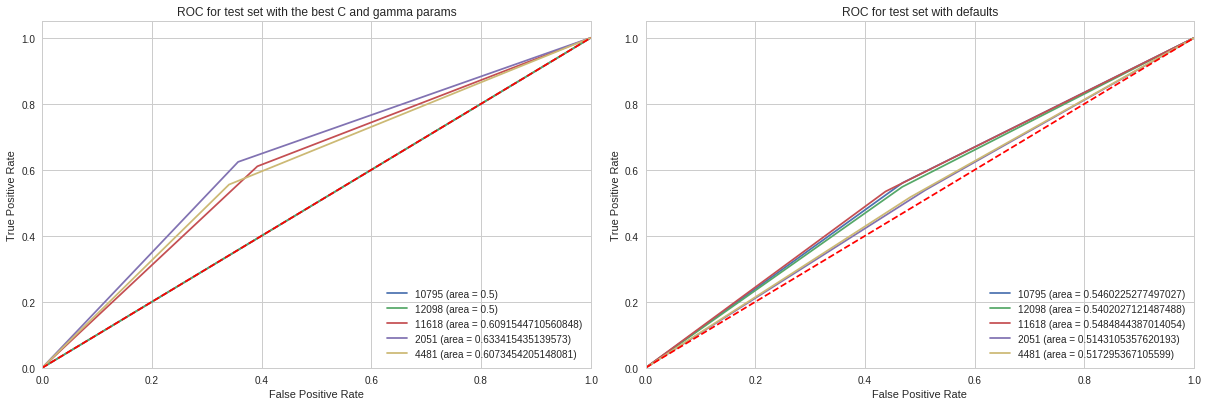

In [16]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(
        dfs[s], 'sigmoid', C=df_css[s]['roc'].idxmax(), gamma=df_gammas[s]['roc'].idxmax(),
        coef0=df_coefs[s]['roc'].idxmax())
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    df_results['sigmoid-tunned'][s] = logit_roc_auc
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with the best C and gamma params')
plt.legend(loc="lower right")


colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'sigmoid')
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    df_results['sigmoid-default'][s] = logit_roc_auc
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with defaults')
plt.legend(loc="lower right")
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

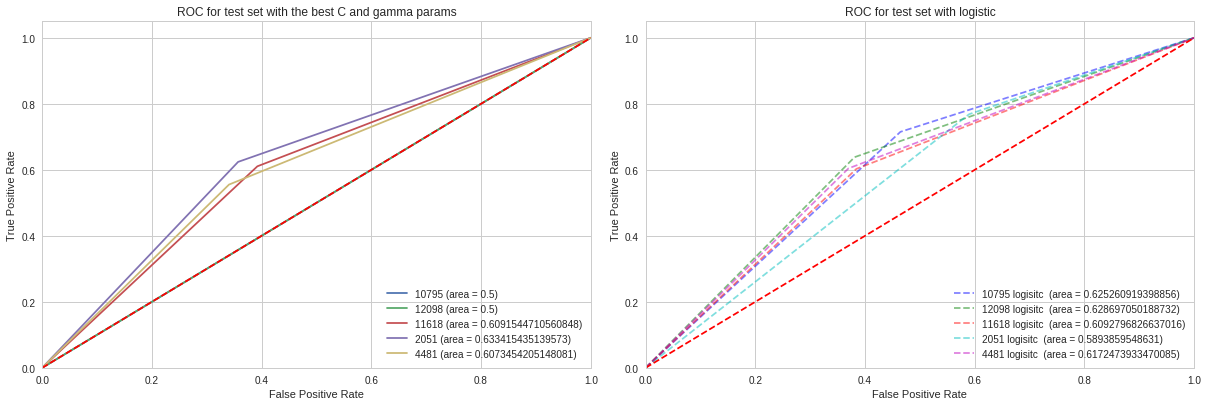

In [19]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(
        dfs[s], 'sigmoid', C=df_css[s]['roc'].idxmax(), gamma=df_gammas[s]['roc'].idxmax(),
        coef0=df_coefs[s]['roc'].idxmax())
    prediction = reg_svm.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], prediction)
    df_results['sigmoid-tunned'][s] = logit_roc_auc
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, prediction)
    plt.plot(fpr, tpr, label='{} (area = {})'.format(s, logit_roc_auc))
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with the best C and gamma params')
plt.legend(loc="lower right")


colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.subplot(122)
for s in stocks:
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    pred_log = reg_log.predict(dfs_test[s]['queue_imbalance'].values.reshape(-1, 1))
    logit_roc_auc = roc_auc_score(dfs_test[s]['mid_price_indicator'], pred_log)
    df_results['logistic'][s] = logit_roc_auc
    fpr, tpr, thresholds = roc_curve(dfs_test[s]['mid_price_indicator'].values, pred_log)
    plt.plot(fpr, tpr, c=colors[stocks.index(s)], linestyle='--', 
             label='{} (area = {})'.format(s + ' logisitc ', logit_roc_auc), alpha=0.5)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for test set with logistic')
plt.legend(loc="lower right")
plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [20]:
df_results

,logistic,sigmoid-default,sigmoid-tunned
10795,0.625261,0.546023,0.500000
12098,0.628697,0.540203,0.500000
11618,0.609280,0.548484,0.609154
2051,0.589386,0.514311,0.633415
4481,0.617247,0.517295,0.607345


# Conclusions


We didn't use valid grid approach for choosing the best parameters, so there is possibility that these parameters could be improved. For one stock **2051** we have significant improvement (even when we consider other results). For stock **11618** we have small improvement.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a>